Run 1/3
DSMAL is optimizing  "f1"
Run 2/3
DSMAL is optimizing  "f1"
Run 3/3
DSMAL is optimizing  "f1"


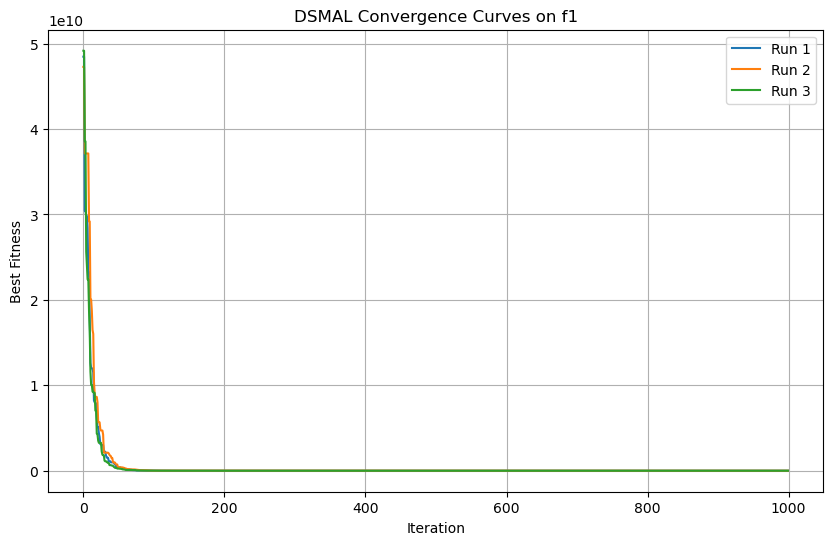

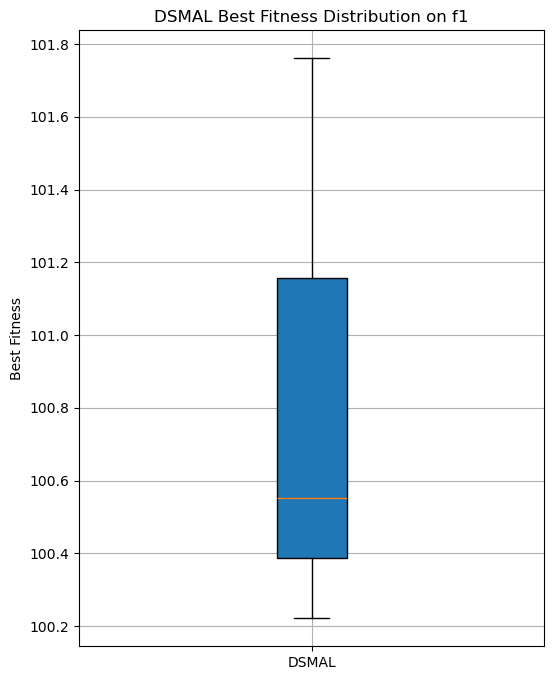

Best fitness values across 3 runs: [101.76112463036922, 100.55246361714498, 100.22148893390438]
Mean best fitness: 100.84502572713951
Standard deviation of best fitness: 0.6617219761654898


In [2]:
import random
import numpy
import math
import time
import opfunu
import pytest
from numpy import abs, zeros, log10, where, arctanh, tanh
from numpy.random import uniform, standard_cauchy
import matplotlib.pyplot as plt

class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

# DSMAL Algorithm implementation
def DSMAL(objf, lb, ub, dim, PopSize, iters, function_name, z=0.03, verbose=False):
    Convergence_curve = numpy.zeros(iters)
    
    # Initialize solution object
    sol = solution()
    
    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
        
    # Algorithm constants
    ID_MIN_PROB = 0  # min problem
    ID_MAX_PROB = -1  # max problem
    ID_POS = 0  # Position
    ID_FIT = 1  # Fitness
    ID_WEI = 2  # Weight
    EPSILON = 10E-10

    # Helper functions for DSMAL
    def amend_position_faster(position, lb, ub):
        return numpy.clip(position, lb, ub)

    def create_solution(lb, ub, obj_func, dim, minmax=0):
        position = uniform(lb, ub)
        fitness = obj_func.evaluate(position)
        weight = zeros(dim)
        return [position, fitness, weight]

    def get_sorted_pop_and_global_best_solution(pop=None, id_fit=None, id_best=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fit])
        return sorted_pop, sorted_pop[id_best].copy()

    def update_sorted_population_and_global_best_solution(pop=None, id_best=None, g_best=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[ID_FIT])
        current_best = sorted_pop[id_best]
        if current_best[ID_FIT] < g_best[ID_FIT]:
            g_best = current_best.copy()
        return sorted_pop, g_best

    def _mutation__(current_pos, new_pos, dim, crossover_ratio, lb, ub):
        pos_new = numpy.where(numpy.random.uniform(0, 1, dim) < crossover_ratio, current_pos, new_pos)
        return amend_position_faster(pos_new, lb, ub)

    # Initialize population
    pop = [create_solution(lb, ub, objf, dim) for _ in range(PopSize)]
    pop, g_best = get_sorted_pop_and_global_best_solution(pop=pop, id_fit=ID_FIT, id_best=ID_MIN_PROB)

    print('DSMAL is optimizing  "' + function_name + '"')
    timerStart = time.time()
    sol.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    # Main optimization loop
    for epoch in range(iters):
        beta = 0.2 + (1.2 - 0.2) * (1 - (epoch / iters) ** 3) ** 2
        alpha = abs(beta * math.sin((3 * math.pi / 2 + math.sin(3 * math.pi / 2 * beta))))
        
        c1 = 2 * numpy.exp(-((4 * (epoch + 1) / iters) ** 2))
        L = numpy.ceil(PopSize * (epoch / (iters + 1)))
        s = g_best[ID_FIT] - pop[-1][ID_FIT] + EPSILON
        
        # Update weights
        for i in range(0, PopSize):
            if i <= int(PopSize / 2):
                pop[i][ID_WEI] = 1 + uniform(0, 1, dim) * log10((g_best[ID_FIT] - pop[i][ID_FIT]) / s + 1)
            else:
                pop[i][ID_WEI] = 1 - uniform(0, 1, dim) * log10((g_best[ID_FIT] - pop[i][ID_FIT]) / s + 1)
                
        a = arctanh(-((epoch + 1) / iters) + 1)
        b = 1 - (epoch + 1) / iters
        mutation_factor = 0.5
        crossover_ratio = 0.7

        # Update positions
        for i in range(0, PopSize):
            if i < PopSize / 2:
                pos_new = uniform(lb, ub)
                ids_except_current = [_ for _ in range(PopSize) if _ != i]
                id_1, id_2, id_3 = random.sample(ids_except_current, 3)
                pos_new = pop[id_1][ID_POS] + mutation_factor * (pop[id_2][ID_POS] - pop[id_3][ID_POS])
                pos_new = _mutation__(pop[i][ID_POS], pos_new, dim, crossover_ratio, lb, ub)
                
            elif i >= PopSize / 2 and i < PopSize + 1:
                p = tanh(abs(pop[i][ID_FIT] - g_best[ID_FIT]))
                vb = uniform(-a, a, dim)
                vc = uniform(-b, b, dim)
                id_a, id_b = random.sample(list(set(range(0, PopSize)) - {i}), 2)
                
                pos_1 = g_best[ID_POS] + vb * (pop[i][ID_WEI] * pop[id_a][ID_POS] - pop[id_b][ID_POS])
                pos_2 = vc * pop[i][ID_POS]
                pos_new = numpy.where(uniform(0, 1, dim) < p, pos_1, pos_2)

            # LEO mechanism
            LC = 4 * LC * (1 - LC)
            if random.random() < LC:
                ids_except_current = [_ for _ in range(PopSize) if _ != i]
                id_1, id_2, k = random.sample(ids_except_current, 3)
                L2 = 1 if random.random() < 0.5 else 0
                Xp = (1 - L2) * pos_new + (L2) * pop[k][ID_POS]

                if random.random() < 0.5 * (1 - (epoch / iters)):
                    pos_new = pos_new + ((g_best[ID_POS] - Xp) + (random.random()) * (pop[id_1][ID_POS] - pop[id_2][ID_POS]))
                else:
                    pos_new = g_best[ID_POS] + ((g_best[ID_POS] - Xp) + (random.random()) * (pop[id_1][ID_POS] - pop[id_2][ID_POS]))

            # Boundary check and evaluation
            pos_new = amend_position_faster(pos_new, lb, ub)
            Xnew_Cost = objf.evaluate(pos_new)
            
            # Update if better solution found
            if Xnew_Cost < pop[i][ID_FIT]:
                pop[i][ID_FIT] = Xnew_Cost
                pop[i][ID_POS] = pos_new
                if pop[i][ID_FIT] < g_best[ID_FIT]:
                    g_best[ID_POS] = pop[i][ID_POS].copy()
                    g_best[ID_FIT] = pop[i][ID_FIT]

        # Update global best and convergence curve
        pop, g_best = update_sorted_population_and_global_best_solution(pop, ID_MIN_PROB, g_best)
        Convergence_curve[epoch] = g_best[ID_FIT]
        
        if verbose and (epoch % 100 == 0):
            print(f"> Epoch: {epoch + 1}, Best fit: {g_best[ID_FIT]}")

    timerEnd = time.time()
    sol.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    sol.executionTime = timerEnd - timerStart
    sol.convergence = Convergence_curve
    sol.optimizer = "DSMAL"
    sol.objfname = function_name
    sol.best = g_best[ID_FIT]
    sol.bestIndividual = g_best[ID_POS]
    return sol

# Parameters
NumOfRuns = 3
dim = 20
PopSize = 30
iters = 1000
lb = -100
ub = 100
function_name = "f1"

if function_name == "f1":
    problem = opfunu.cec_based.F12021(ndim=dim)
elif function_name == "f2":
    problem = opfunu.cec_based.F22021(ndim=dim)
elif function_name == "f3":
    problem = opfunu.cec_based.F32021(ndim=dim)
elif function_name == "f4":
    problem = opfunu.cec_based.F42021(ndim=dim)
elif function_name == "f5":
    problem = opfunu.cec_based.F52021(ndim=dim)
elif function_name == "f6":
    problem = opfunu.cec_based.F62021(ndim=dim)
elif function_name == "f7":
    problem = opfunu.cec_based.F72021(ndim=dim)
elif function_name == "f8":
    problem = opfunu.cec_based.F82021(ndim=dim)
elif function_name == "f9":
    problem = opfunu.cec_based.F92021(ndim=dim)
elif function_name == "f10":
    problem = opfunu.cec_based.F102021(ndim=dim)   
else:
    print("the objective Function is Not belongs to CEC2021")

# Run DSMAL multiple times and collect results
best_fitness_values = []
convergence_curves = []

for run in range(NumOfRuns):
    print(f"Run {run + 1}/{NumOfRuns}")
    s = DSMAL(problem, lb, ub, dim, PopSize, iters, function_name)
    best_fitness_values.append(s.best)
    convergence_curves.append(s.convergence)

# Plot convergence curves
plt.figure(figsize=(10, 6))
for run in range(NumOfRuns):
    plt.plot(convergence_curves[run], label=f'Run {run + 1}')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.title(f'DSMAL Convergence Curves on {function_name}')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# Plot box plot
plt.figure(figsize=(6, 8))
plt.boxplot(best_fitness_values, vert=True, patch_artist=True)
plt.ylabel('Best Fitness')
plt.title(f'DSMAL Best Fitness Distribution on {function_name}')
plt.xticks([1], ['DSMAL'])
plt.grid(True)
plt.show()

print(f"Best fitness values across {NumOfRuns} runs: {best_fitness_values}")
print(f"Mean best fitness: {numpy.mean(best_fitness_values)}")
print(f"Standard deviation of best fitness: {numpy.std(best_fitness_values)}")